In [21]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from functools import partial
# from NeuralNet import *
from timeit import default_timer

from Solver import *
import sys
sys.path.append('../Utility')
import NeuralNet
from Numerics import gradient_first


# Load data

In [22]:
N_y = 384
beta = 1.0
tau_inv = [0.01, 0.02, 0.04, 0.08, 0.16]
N_data = len(tau_inv)
data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]

#data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_0.01/"]

N_data = len(data_dirs)
closure_mean,  q_mean, dq_dy_mean = np.zeros((N_data,N_y)), np.zeros((N_data,N_y)), np.zeros((N_data,N_y))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dy_mean[i, :] = load_data(data_dirs[i])
q_mean_abs = np.fabs(q_mean)  
mu_f = closure_mean/dq_dy_mean
L = 4*np.pi
yy = np.linspace(-L/2.0, L/2.0, N_y)
dy = yy[1] - yy[0]


# q_jet 
omega_jet = np.zeros(N_y)
omega_jet[0:N_y//2] = 1.0
omega_jet[N_y//2:N_y] = -1.0
q_jet = omega_jet + beta*yy

# Clean data

In [24]:
chop_l = 50

for i in range(N_data):  
    q_mean[i, 0:chop_l] = np.linspace(q_jet[0],   q_mean[i,chop_l-1],  chop_l)   #q_jet[0:chop_l]
    q_mean[i, -chop_l:] = np.linspace(q_mean[i, -chop_l], q_jet[-1],  chop_l)   #q_jet[-chop_l:]
    q_mean_abs[i, 0:chop_l] = np.fabs(q_mean[i, 0:chop_l])
    q_mean_abs[i, -chop_l:] = np.fabs(q_mean[i, -chop_l:])
    
    
    dq_dy_mean[i, 0:chop_l] = np.linspace(beta, dq_dy_mean[i,chop_l-1],  chop_l)
    dq_dy_mean[i, -chop_l:] = np.linspace(dq_dy_mean[i, -chop_l], beta, chop_l)
    
    closure_mean[i, 0:chop_l] = np.linspace(0.0, closure_mean[i,chop_l-1],  chop_l)
    closure_mean[i, -chop_l:] = np.linspace(closure_mean[i, -chop_l], 0.0, chop_l)
    
    mu_f[i, 0:chop_l] = closure_mean[i, 0:chop_l]/dq_dy_mean[i, 0:chop_l] 
    mu_f[i, -chop_l:] = closure_mean[i, -chop_l:]/dq_dy_mean[i, -chop_l:]
    
    
# TODO: clean data
mu_f[mu_f >= 0.1 ] = 0.0
mu_f[mu_f <= 0.0 ] = 0.0
for i in range(N_data):
    mu_f[i,:] = scipy.ndimage.gaussian_filter1d(mu_f[i,:], 5)



# Visualize data

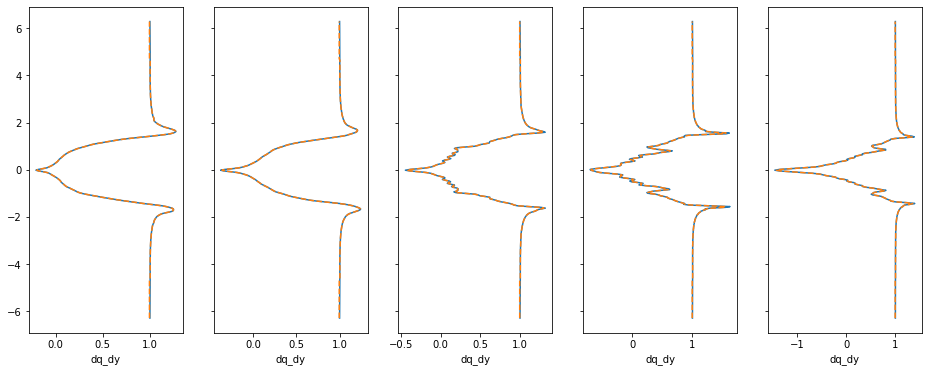

In [25]:
# compare dq_dy_mean vs dq_dy
dq_mean_dy = np.zeros(dq_dy_mean.shape)
for i in range(N_data): 
    dq_mean_dy[i, :] = gradient_first(q_mean[i, :], dy, bc = "one-sided")

fig, ax = plt.subplots(nrows=1, ncols=N_data, sharex=False, sharey=True, figsize=(16,6))
for i in range(N_data):
    ax[i].plot(dq_dy_mean[i,:], yy)
    ax[i].plot(dq_mean_dy[i,:], yy, "--")
    ax[i].set_xlabel("dq_dy")
    

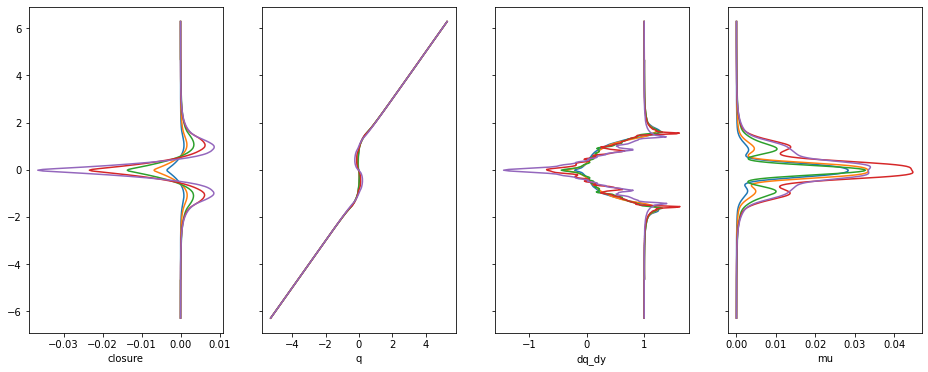

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=True, figsize=(16,6))
for i in range(N_data):
    ax[0].plot(closure_mean[i,:], yy)
    ax[1].plot(q_mean[i,:], yy)
    ax[2].plot(dq_dy_mean[i,:], yy)
    ax[3].plot(mu_f[i,:], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dq_dy")
    ax[3].set_xlabel("mu")


In [18]:
nn_save_name = "visc.model"
x_train = torch.from_numpy(np.stack((q_mean_abs.flatten(), dq_dy_mean.flatten())).T.astype(np.float32)) 
y_train = torch.from_numpy(mu_f.flatten()[:,np.newaxis].astype(np.float32)) / mu_scale

ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 10000
gamma = 0.1  
epochs = 50000
batch_size = 1024 #64

layers = 2
width  = 10
activation='sigmoid'
initializer='default'
outputlayer='None'
torch.manual_seed(0)


net = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer) 
optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
for ep in range(epochs):
    net.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        
        optimizer.zero_grad()
        
        out = net(x)
        loss = myloss(out , y)*1000
        loss.backward()
        
        optimizer.step()
        train_l2 += loss.item()

# TODO reducing learning rate 
#     scheduler.step()

    if ep % 1000 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
        if nn_save_name is not None:
            torch.save(net, nn_save_name)
        
       

Epoch :  0  Epoch time :  0.07115079299546778  Train L2 Loss :  1608275.75
Epoch :  1000  Epoch time :  0.010848909034393728  Train L2 Loss :  282026.2109375
Epoch :  2000  Epoch time :  0.00954671303043142  Train L2 Loss :  210156.90625
Epoch :  3000  Epoch time :  0.01050051802303642  Train L2 Loss :  175735.1171875
Epoch :  4000  Epoch time :  0.010763138008769602  Train L2 Loss :  140680.953125
Epoch :  5000  Epoch time :  0.05624914198415354  Train L2 Loss :  108591.59375
Epoch :  6000  Epoch time :  0.010820663999766111  Train L2 Loss :  87218.90625
Epoch :  7000  Epoch time :  0.010528860031627119  Train L2 Loss :  78289.03515625
Epoch :  8000  Epoch time :  0.010661343985702842  Train L2 Loss :  74565.953125
Epoch :  9000  Epoch time :  0.010876621992792934  Train L2 Loss :  72308.3359375
Epoch :  10000  Epoch time :  0.010669693001545966  Train L2 Loss :  70727.6484375
Epoch :  11000  Epoch time :  0.010732683993410319  Train L2 Loss :  69551.4140625
Epoch :  12000  Epoch time

# Test on training data

/central/home/dzhuang/Code/Point-Jet/Point_jet/Solver.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten() * mu_scale


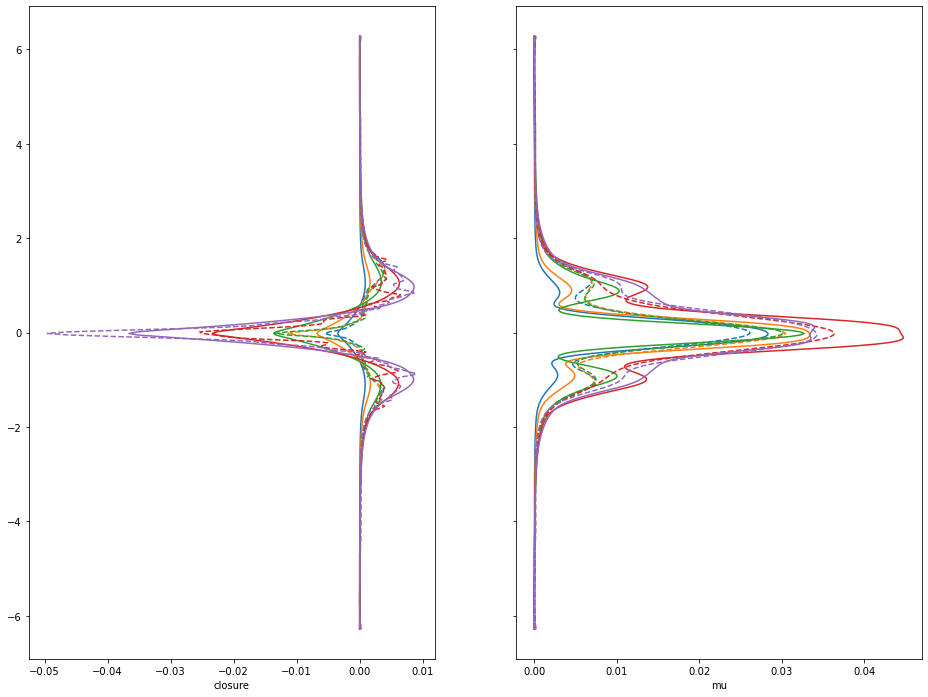

In [19]:
y_pred = net_eval(x_train, net).reshape((N_data, N_y))

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(16,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,:], yy, color="C"+str(i))
    ax[0].plot(y_pred[i,:]*dq_dy_mean[i,:], yy, "--", color="C"+str(i))
    
    ax[1].plot(mu_f[i,:], yy, color="C"+str(i))    
    ax[1].plot(y_pred[i,:], yy, "--", color="C"+str(i))
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("mu")
    


# Plug-in test

1000 max q 5.283185307179586
2000 max q 5.283185307179586
3000 max q 5.283185307179586
4000 max q 5.283185307179586
5000 max q 5.283185307179586
6000 max q 5.283185307179586
7000 max q 5.283185307179586
8000 max q 5.283185307179586
9000 max q 5.283185307179586
10000 max q 5.283185307179586
11000 max q 5.283185307179586
12000 max q 5.283185307179586
13000 max q 5.283185307179586
14000 max q 5.283185307179586
15000 max q 5.283185307179586
16000 max q 5.283185307179586
17000 max q 5.283185307179586
18000 max q 5.283185307179586
19000 max q 5.283185307179586
20000 max q 5.283185307179586
21000 max q 5.283185307179586
22000 max q 5.283185307179586
23000 max q 5.283185307179586
24000 max q 5.283185307179586
25000 max q 5.283185307179586
26000 max q 5.283185307179586
27000 max q 5.283185307179586
28000 max q 5.283185307179586
29000 max q 5.283185307179586
30000 max q 5.283185307179586
31000 max q 5.283185307179586
32000 max q 5.283185307179586
33000 max q 5.283185307179586
34000 max q 5.28318

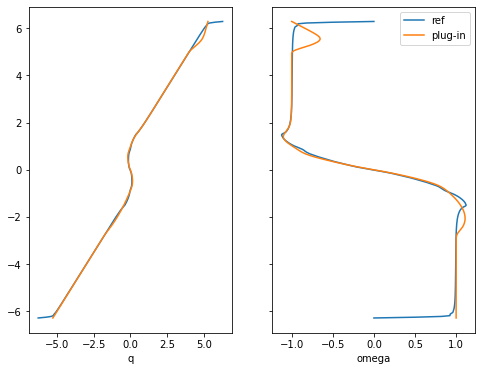

In [20]:
tau_inv = "0.08"                                                                                                               
tau = 1/float(tau_inv)
data_dir = "../data/beta_1.0_Gamma_1.0_relax_" + tau_inv + "/"
dq_dy = scipy.io.loadmat(data_dir+"data_dq_dy.mat")["data_dq_dy"]
closure = scipy.io.loadmat(data_dir+"data_closure_cons.mat")["data_closure_cons"]
w = scipy.io.loadmat(data_dir+"data_w.mat")["data_w"]
q = scipy.io.loadmat(data_dir+"data_q.mat")["data_q"]

_, Ny, Nt = q.shape
q_mean = np.mean(q[0, :, Nt//2:], axis=1)
w_mean = np.mean(w[0, :, Nt//2:], axis=1)


nn_model = partial(nn_flux, net)

model = lambda q, yy, res : nummodel_flux(nn_model, q, yy, res)
dt, Nt, save_every = 1.0e-4, 200000, 1000
yy, t_pred, q_pred = explicit_solve(model, q_jet, tau, dt, Nt, save_every, L = 4*np.pi)
q_mean_pred = np.mean(q_pred[Nt//(2*save_every):, :], axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(8,6))


ax[0].plot(q_mean, yy,   label="ref")                                                                         
ax[0].plot(q_mean_pred, yy, label="plug-in")
ax[1].plot(w_mean, yy,   label="ref")                                                                         
ax[1].plot(q_mean_pred - beta*yy, yy, label="plug-in")
ax[0].set_xlabel("q")
ax[1].set_xlabel("omega")
                                                                                                            
plt.legend()
plt.show()
                                                                                      
                                                                        